#Import libraries

In [1]:
!pip install pandas torch transformers datasets scikit-learn

In [2]:
import torch

#Set device

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')  # CUDA GPU
elif torch.backends.mps.is_available():
    device = torch.device('mps') #Apple GPU
else:
    device = torch.device("cpu")

In [4]:
print('Using device:', device)
#Additional Info when using cuda
if device.type == 'cuda':
    print("Device name: ", torch.cuda.get_device_name(0))
    print("Device properties:", torch.cuda.get_device_properties(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
Device name:  Tesla T4
Device properties: _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


#Load dataset

In [5]:
import pandas as pd
from datasets import load_dataset
import numpy as np

In [6]:
review_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023","raw_review_All_Beauty")

# User Reviews dataframe (reviews are in the 'train' split)
reviews_df = pd.DataFrame(review_dataset['full'])

In [7]:
# Map user_id and parent_asin to indices
user_map = {user: idx for idx, user in enumerate(reviews_df["user_id"].unique())}
item_map = {asin: idx for idx, asin in enumerate(reviews_df["parent_asin"].unique())}


In [8]:
meta_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023","raw_meta_All_Beauty")

# User Reviews dataframe (reviews are in the 'train' split)
meta_df = pd.DataFrame(meta_dataset['full'])

#Split data

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
reviews_df["user_idx"] = reviews_df["user_id"].map(user_map)
reviews_df["item_idx"] = reviews_df["parent_asin"].map(item_map)

# Train-test split
train, test = train_test_split(reviews_df, test_size=0.2, random_state=42)

#NCF model

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=32, hidden_dims=[64, 32], dropout_rate=0.5):
        super(NCF, self).__init__()
        # Embedding layers
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        # Neural layers
        input_dim = embedding_dim * 2
        layers = []
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim
        self.mlp = nn.Sequential(*layers)

        # Final prediction layer
        self.output = nn.Linear(hidden_dims[-1], 1)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, user_idx, item_idx):
        # Embeddings
        user_emb = self.user_embedding(user_idx)
        item_emb = self.item_embedding(item_idx)

        # Concatenate and pass through MLP
        x = torch.cat([user_emb, item_emb], dim=-1)
        x = self.mlp(x)

        x = self.dropout(x)

        # Prediction
        return torch.sigmoid(self.output(x))


#prepare dataloader

In [12]:
from torch.utils.data import Dataset, DataLoader

class ReviewsDataset(Dataset):
    def __init__(self, data):
        self.user_idx = data["user_idx"].values
        self.item_idx = data["item_idx"].values
        self.rating = data["rating"].values

    def __len__(self):
        return len(self.rating)

    def __getitem__(self, idx):
        return {
            "user_idx": torch.tensor(self.user_idx[idx], dtype=torch.long),
            "item_idx": torch.tensor(self.item_idx[idx], dtype=torch.long),
            "rating": torch.tensor(self.rating[idx], dtype=torch.float),
        }

# Create DataLoaders
train_dataset = ReviewsDataset(train)
test_dataset = ReviewsDataset(test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


#train

In [13]:
results = {"train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []
    }

In [14]:
def train_model(model, train_loader, test_loader, epochs=10, lr=0.001, lr_decay_step=5, lr_decay_gamma=0.1):
    model.to("cuda")  # Move model to GPU
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_gamma)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_mae = 0
        for batch in train_loader:
            user_idx = batch["user_idx"].to("cuda")
            item_idx = batch["item_idx"].to("cuda")
            ratings = batch["rating"].to("cuda")

            optimizer.zero_grad()
            predictions = model(user_idx, item_idx).squeeze()
            loss = criterion(predictions, ratings / 5.0)  # Normalize ratings
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_mae += torch.abs(predictions - (ratings / 5.0)).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_train_mae = train_mae / len(train_loader.dataset)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader):.4f}, Train MAE: {avg_train_mae:.4f}")
        results["train_loss"].append(train_loss / len(train_loader))
        results["train_acc"].append(avg_train_mae)

        scheduler.step()

        evaluate_model(model, test_loader)

def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    test_mae = 0
    with torch.no_grad():
        for batch in test_loader:
            user_idx = batch["user_idx"].to("cuda")
            item_idx = batch["item_idx"].to("cuda")
            ratings = batch["rating"].to("cuda")

            predictions = model(user_idx, item_idx).squeeze()
            loss = nn.MSELoss()(predictions, ratings / 5.0)

            test_loss += loss.item()
            test_mae += torch.abs(predictions - (ratings / 5.0)).sum().item()

        avg_test_loss = test_loss / len(test_loader)
        avg_test_mae = test_mae / len(test_loader.dataset)

    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test MAE: {avg_test_mae:.4f}")
    results["test_loss"].append(test_loss / len(test_loader))
    results["test_acc"].append(avg_test_mae)


In [16]:
num_users = len(user_map)
num_items = len(item_map)

# Initialize model
ncf_model = NCF(num_users=num_users, num_items=num_items, embedding_dim=32, hidden_dims=[64, 32])

# Train the model
train_model(ncf_model, train_loader, test_loader, epochs=10, lr=1e-4)


Epoch 1, Train Loss: 0.1007, Train MAE: 0.2854
Test Loss: 0.0904, Test MAE: 0.2650
Epoch 2, Train Loss: 0.0918, Train MAE: 0.2655
Test Loss: 0.0903, Test MAE: 0.2646
Epoch 3, Train Loss: 0.0913, Train MAE: 0.2648
Test Loss: 0.0902, Test MAE: 0.2640
Epoch 4, Train Loss: 0.0909, Train MAE: 0.2642
Test Loss: 0.0902, Test MAE: 0.2636
Epoch 5, Train Loss: 0.0906, Train MAE: 0.2636
Test Loss: 0.0902, Test MAE: 0.2635
Epoch 6, Train Loss: 0.0905, Train MAE: 0.2635
Test Loss: 0.0902, Test MAE: 0.2636
Epoch 7, Train Loss: 0.0905, Train MAE: 0.2636
Test Loss: 0.0902, Test MAE: 0.2637
Epoch 8, Train Loss: 0.0905, Train MAE: 0.2636
Test Loss: 0.0902, Test MAE: 0.2636
Epoch 9, Train Loss: 0.0904, Train MAE: 0.2636
Test Loss: 0.0902, Test MAE: 0.2635
Epoch 10, Train Loss: 0.0904, Train MAE: 0.2634
Test Loss: 0.0902, Test MAE: 0.2636


#Plot

In [17]:
import matplotlib.pyplot as plt
# Plot loss curves of a model
def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

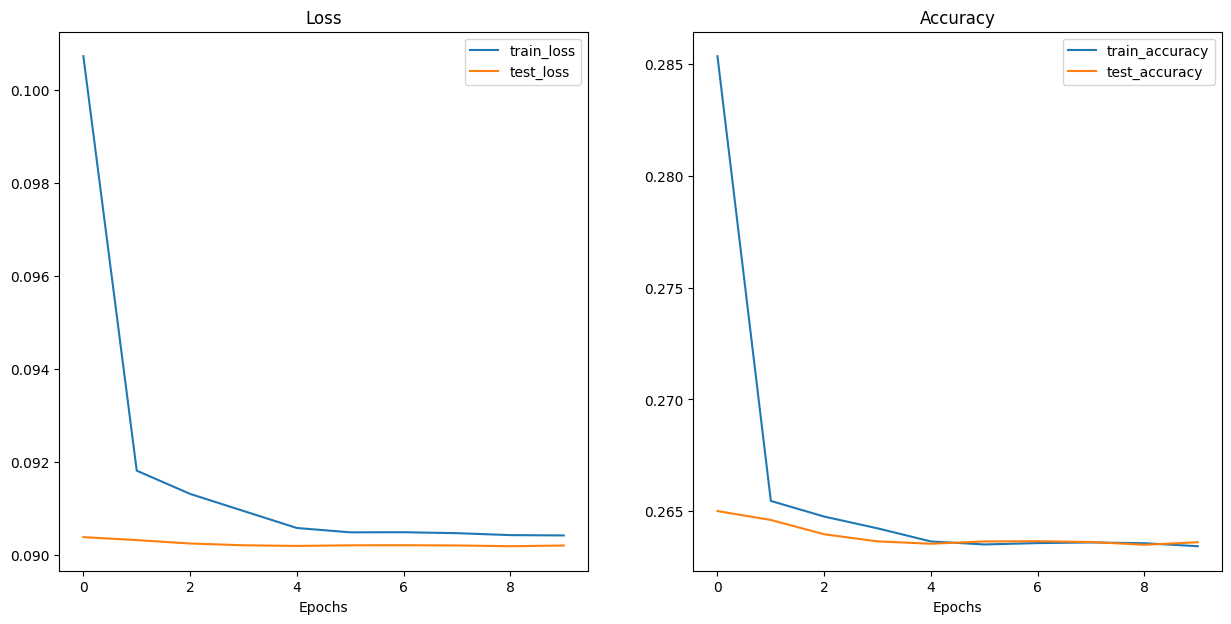

In [18]:
plot_loss_curves(results)

#Recommendations

In [19]:
# Example recommendation for a user
user_id = "AHZM3GVSTF4MCGO67QFLXCNIXSIQ"
user_index = user_map[user_id]

In [20]:
def recommend(model, user_idx, item_indices, k=10):
    model.eval()
    user_tensor = torch.tensor([user_idx] * len(item_indices)).to("cuda")
    item_tensor = torch.tensor(item_indices).to("cuda")

    with torch.no_grad():
        predictions = model(user_tensor, item_tensor).squeeze()
    top_k_items = torch.topk(predictions, k=k).indices.cpu().numpy()
    return [list(item_map.keys())[i] for i in top_k_items]


item_indices = list(range(len(item_map)))
recommendations = recommend(ncf_model, user_index, item_indices)
print("Recommended items:", recommendations)


Recommended items: ['B08BBQ29N5', 'B099DRHW5V', 'B08BZ63GMJ', 'B00R8DXL44', 'B081TJ8YS3', 'B00YQ6X8EO', 'B097R46CSY', 'B09JS339BZ', 'B08P2DZB4X', 'B086QY6T7N']


In [ ]:
# import matplotlib.pyplot as plt
# from PIL import Image
# import requests
# from io import BytesIO

# def fetch_item_images_from_df(asins, meta_df):
    
#     items_with_images = []
#     for asin in asins:
#         row = meta_df[meta_df["parent_asin"] == asin]
#         if not row.empty:
#             images = row["images"].iloc[0]
#             if images:  # Check if images are available
#               #print(images["large"][0])
#               items_with_images.append((asin, images["large"][0], row["title"]))
#     return items_with_images

# def display_items(title, items):
#     print(items)
    
#     plt.figure(figsize=(15, 5))
#     plt.suptitle(title, fontsize=16)

#     for idx, (asin, image_urls, title) in enumerate(items):
#         if image_urls:  # Only display if images are available
#             try:
#                 response = requests.get(image_urls)
#                 img = Image.open(BytesIO(response.content))

#                 plt.subplot(1, len(items), idx + 1)
#                 plt.imshow(img)
#                 plt.axis("off")
#                 plt.title(title)
#             except Exception as e:
#                 print(f"Could not fetch image for ASIN {asin}: {e}")

#     plt.tight_layout()
#     plt.show()


# # Fetch ASINs for bought items
# #user_id = "user_1"
# bought_asins = reviews_df[reviews_df["user_id"] == user_id]["asin"].tolist()

# # Fetch images for recommended items
# recommended_asins = recommend(ncf_model, user_index, list(range(len(item_map))))
# bought_items = fetch_item_images_from_df(bought_asins, meta_df)
# recommended_items = fetch_item_images_from_df(recommended_asins, meta_df)

# # Display images
# display_items("User Bought Items", bought_items)
# display_items("Recommended Items", recommended_items)


In [26]:
import gradio as gr
import torch
from PIL import Image
import requests
from io import BytesIO

# Function to fetch item images from the DataFrame
def fetch_item_images_from_df(asins, meta_df):
    items_with_images = []
    for asin in asins:
        row = meta_df[meta_df["parent_asin"] == asin]
        if not row.empty:
            images = row["images"].iloc[0]
            if images:  # Check if images are available
                items_with_images.append([images["large"][0], row["title"].iloc[0]])
    return items_with_images

# Function to recommend and fetch images for bought and recommended items
def recommend_and_display(user_id):
    user_index = user_map.get(user_id)
    if user_index is None:
        return [], []  # Return empty lists if user not found

    # Fetch ASINs for bought items
    bought_asins = reviews_df[reviews_df["user_id"] == user_id]["parent_asin"].tolist()

    # Fetch images for bought and recommended items
    bought_items = fetch_item_images_from_df(bought_asins, meta_df)
    recommended_asins = recommend(ncf_model, user_index, list(range(len(item_map))))
    recommended_items = fetch_item_images_from_df(recommended_asins, meta_df)

    return bought_items, recommended_items

# Gradio function to display the recommendations
def gradio_interface(user_id):
    bought, recommended = recommend_and_display(user_id)
    return bought, recommended

# Gradio Interface
interface = gr.Interface(
    fn=gradio_interface,
    inputs=gr.Textbox(label="Enter User ID"),
    outputs=[
        gr.Gallery(label="Bought Items"),
        gr.Gallery(label="Recommended Items")
    ],
    title="Amazon Recommender",
    description="Enter a User ID to see images of bought and recommended items.",
    live=True
)

# Launch Gradio Interface
interface.launch(share=True)


* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://91cd066240022a4c51.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
